In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

modules installed with version

matplotlib                        3.8.4
matplotlib-inline                 0.1.7
numpy                             1.26.4
opencv-python                     4.9.0.80
pandas                            2.2.2
plotly                            5.22.0
streamlit                         1.34.0
streamlit-drawable-canvas         0.9.3
torch                             2.3.0
torchvision                       0.18.0
tqdm                              4.66.2

In [20]:
from torchvision import datasets
from torchvision import transforms as T

In [21]:
# augment the train dataset

train_aug = T.Compose([T.RandomHorizontalFlip(p=0.5),
                      T.RandomVerticalFlip(p=0.5),
                      T.ToTensor(),   # will convert the images from h,w,c to tensors with c= channel, h=height, w=width
                      T.Normalize(mean=0.5, std = 0.5)
                      ])

valid_aug = T.Compose([T.ToTensor(),   # will convert the images from h,w,c to tensors with c= channel, h=height, w=width
                      T.Normalize(mean=0.5, std = 0.5)
                      ])

In [22]:
trainset = datasets.MNIST('./', download = True, train = True, transform = train_aug)

testset = datasets.MNIST('./', download = True, train = False, transform = valid_aug)

In [23]:
trainset , validset = torch.utils.data.random_split(trainset, [50000, 10000])

In [24]:
print(f'size of trainset: {len(trainset)}')
print(f'size of validset: {len(validset)}')
print(f'size of testset: {len(testset)}')

size of trainset: 50000
size of validset: 10000
size of testset: 10000


shape of image : torch.Size([1, 28, 28])
for vizualization we need (hxwxc) so using permute shape will be : torch.Size([28, 28, 1])


Text(0.5, 1.0, '2')

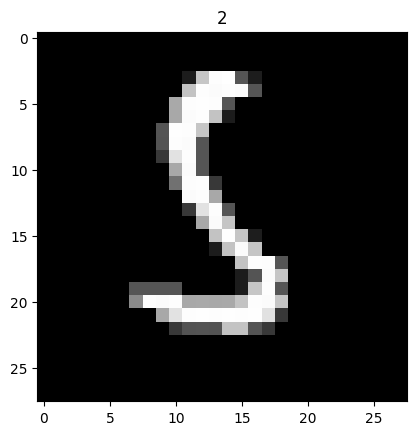

In [25]:
idx = 4
image, label = trainset[idx]

print(f'shape of image : {image.shape}')
permuted_im = image.permute(1,2,0)
print(f'for vizualization we need (hxwxc) so using permute shape will be : {permuted_im.shape}')
plt.imshow(permuted_im, cmap='gray')
plt.title(label)


# Load Data into Batches

In [26]:
from torch.utils.data import DataLoader

In [27]:
batch_size = 64

train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
test_loader  = DataLoader(testset, batch_size = batch_size)
valid_loader = DataLoader(validset, batch_size = batch_size)

In [28]:
print(f'size of train_loader: {len(train_loader)}')
print(f'size of test_loader: {len(test_loader)}')
print(f'size of valid_loader: {len(valid_loader)}')

size of train_loader: 782
size of test_loader: 157
size of valid_loader: 157


In [29]:
for images, labels in train_loader:
    print(f'one image-batch shape is : {images.shape}')
    print(f'one label-batch shape is : {labels.shape}')
    break

one image-batch shape is : torch.Size([64, 1, 28, 28])
one label-batch shape is : torch.Size([64])


# Import custom model from models class

In [30]:
from models import DigitModel

In [31]:
model = DigitModel()
model.to('cpu')

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Evaluate functions

In [14]:
def train_fn(model, dataloader, criterion, optimizer):   # criterion is loss type
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for images, labels in tqdm(dataloader):
        images = images.to('cpu')
        labels = labels.to('cpu')

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += utils.multiclass_accuracy(logits, labels)

    return total_loss / len(dataloader) , total_acc / len(dataloader)

In [15]:
def eval_fn(model, dataloader, criterion):   # criterion is loss type
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        
        for images, labels in tqdm(dataloader):
            images = images.to('cpu')
            labels = labels.to('cpu')
    
            logits = model(images)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            total_acc += utils.multiclass_accuracy(logits, labels)
    
        return total_loss / len(dataloader) , total_acc / len(dataloader)

# Create training loop

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.003)

In [17]:
# initialise best loss
best_valid_loss = np.Inf

for i in range(7):
    train_loss , train_acc = train_fn(model, train_loader, criterion, optimizer)
    valid_loss , valid_acc = eval_fn(model, valid_loader, criterion)

    print(f'Epoch: {i+1}, train_acc: {train_acc}, train_loss: {train_loss}')
    print(f'Epoch: {i+1}, valid_acc: {valid_acc}, valid_loss: {valid_loss}')

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_weights.pt")
        print("Best Model Saved")
        best_valid_loss = valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, train_acc: 0.7454044222831726, train_loss: 0.7451887339391672
Epoch: 1, valid_acc: 0.9245620965957642, valid_loss: 0.2653084032854457
Best Model Saved


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, train_acc: 0.8875879049301147, train_loss: 0.3676849224073503
Epoch: 2, valid_acc: 0.9474522471427917, valid_loss: 0.1762679558793071
Best Model Saved


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, train_acc: 0.9084478616714478, train_loss: 0.2973219072898788
Epoch: 3, valid_acc: 0.9536226391792297, valid_loss: 0.15677228336263993
Best Model Saved


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, train_acc: 0.9224944114685059, train_loss: 0.25772182846827735
Epoch: 4, valid_acc: 0.9616839289665222, valid_loss: 0.12192495316148373
Best Model Saved


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5, train_acc: 0.928388774394989, train_loss: 0.23600070156118907
Epoch: 5, valid_acc: 0.9638733863830566, valid_loss: 0.12235557556650631


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 6, train_acc: 0.9336636662483215, train_loss: 0.2193371933620528
Epoch: 6, valid_acc: 0.9665604829788208, valid_loss: 0.10692634211799759
Best Model Saved


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 7, train_acc: 0.9381793737411499, train_loss: 0.2031941355665779
Epoch: 7, valid_acc: 0.9643710255622864, valid_loss: 0.11193983735528532


# Inference

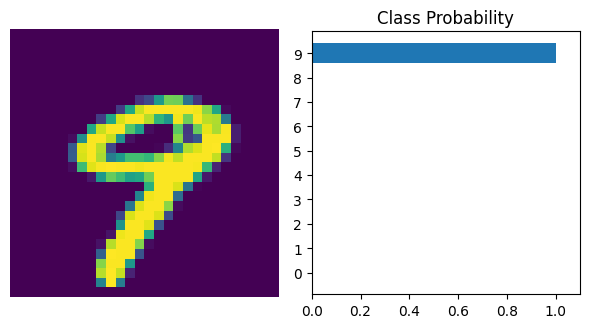

In [37]:
# pass the test image and test the model

image , label = testset[9]
best_weights = torch.load('best_weights.pt')

# load model and attache the best weights to it
model.load_state_dict(best_weights)

# evaluate model for the test image
model.eval()
with torch.no_grad():
    logits = model(image.unsqueeze(0))  ## unsqueezing the image at 0th dim ; (c,h,w)->(1,c,h,w)
    ps = torch.nn.Softmax(dim=1)(logits)[0]
    utils.view_classify(image, ps)